<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-Lasso" data-toc-modified-id="Модель-Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель Lasso</a></span></li><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Ridge</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
!pip install -U scikit-learn -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
print(taxi.info())
print(taxi.describe())
display(taxi.head(10).style.background_gradient(cmap='Blues', axis=0))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
print('\u001b[38;5;19m','Диапазон времени заказа такси от:', taxi.index.min(), 'до:', taxi.index.max(),'\u001b[0m')

 Диапазон времени заказа такси от: 2018-03-01 00:00:00 до: 2018-08-31 23:50:00 


In [7]:
def line_chart(file, column, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    plt.figure(figsize=(14, 6))
    ax = file[column].plot(kind='line', color='steelblue', linewidth=2.5)
    ax.set_title(title, fontsize=20, fontweight="bold", color='darkblue', pad=15)
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

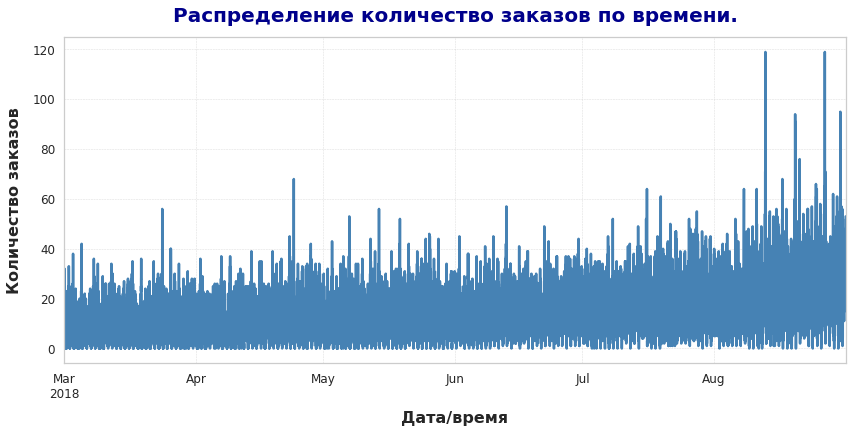

In [8]:
file=taxi
column='num_orders'
title='Распределение количество заказов по времени.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

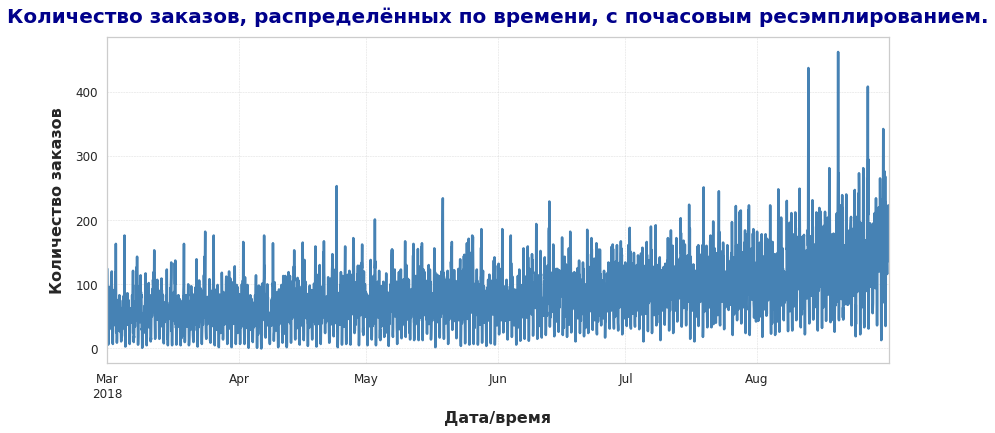

In [9]:
file=taxi.resample('1H').sum()
column='num_orders'
title='Количество заказов, распределённых по времени, с почасовым ресэмплированием.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

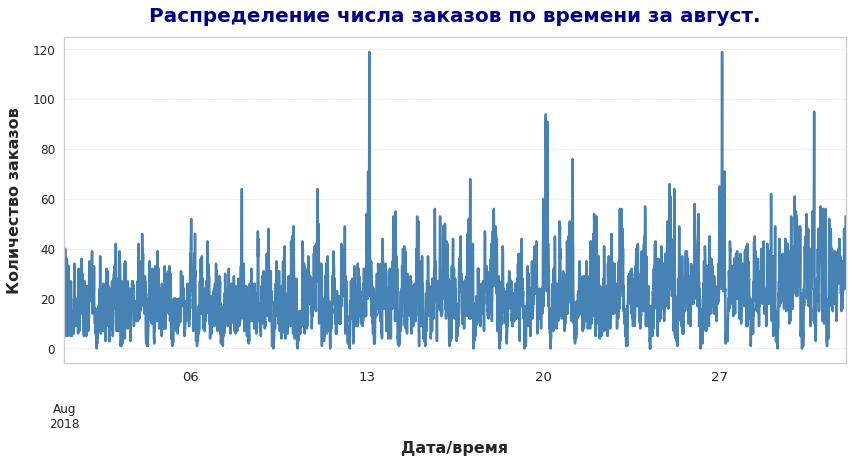

In [10]:
file=taxi['2018-08':'2018-08']
column='num_orders'
title='Распределение числа заказов по времени за август.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

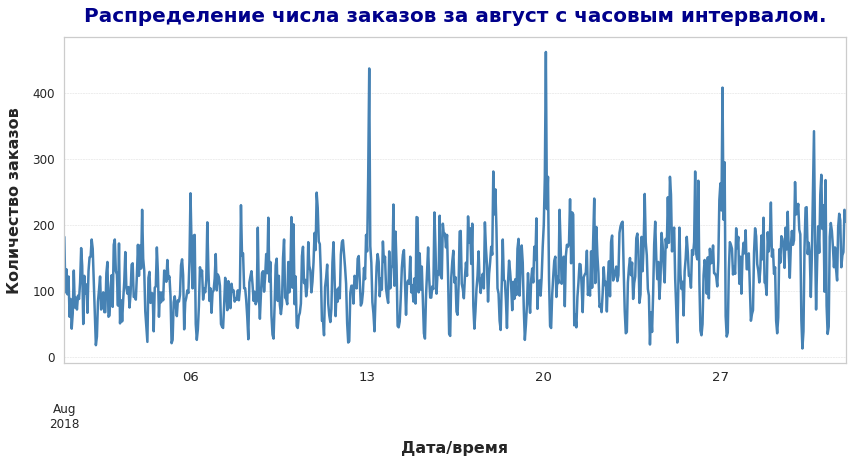

In [11]:
file=taxi['2018-08':'2018-08'].resample('1H').sum()
column='num_orders'
title='Распределение числа заказов за август с часовым интервалом.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

Замечены значительные пики, приходящиеся на выходные и праздничные дни.

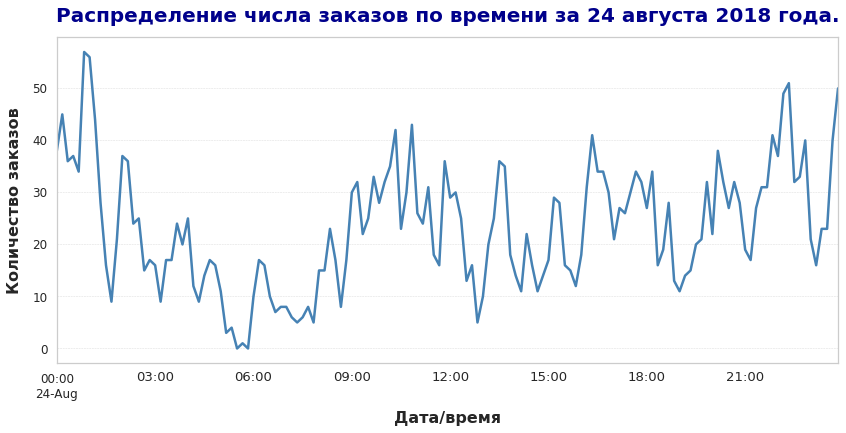

In [12]:
file=taxi['2018-08-24':'2018-08-24']
column='num_orders'
title='Распределение числа заказов по времени за 24 августа 2018 года.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

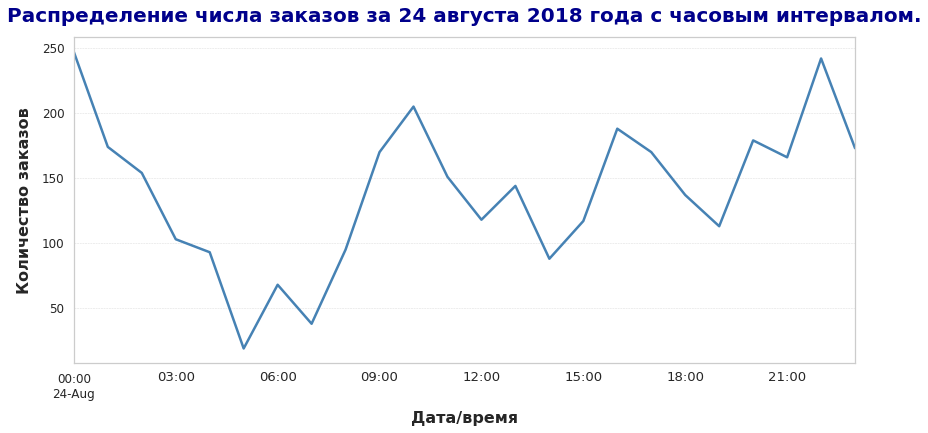

In [13]:
file=taxi['2018-08-24':'2018-08-24'].resample('1H').sum()
column='num_orders'
title='Распределение числа заказов за 24 августа 2018 года с часовым интервалом.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart(file, column, title, xlabel, ylabel)

В ночное время наблюдается заметное снижение спроса на такси.

## Анализ

In [14]:
taxi = taxi.sort_index()
taxi=taxi.resample('1H').sum()

In [15]:
def line_decompose(file, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    plt.figure(figsize=(14, 6))
    ax = file.plot(kind='line', color='steelblue', linewidth=2.5)
    ax.set_title(title, fontsize=20, fontweight="bold", color='darkblue', pad=15)
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [16]:
decomposed = seasonal_decompose(taxi)

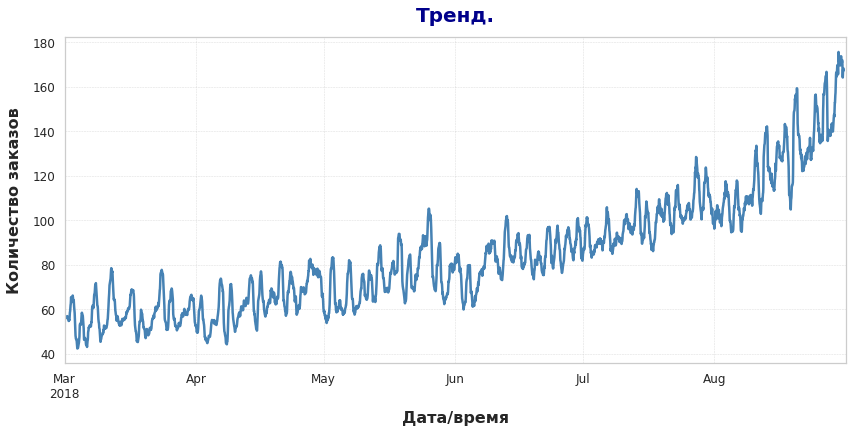

In [17]:
file=decomposed.trend
title='Тренд.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Отмечается тенденция к увеличению числа заказов такси в конце лета. Вероятно, в завершение отпускного сезона люди чаще обращаются за такси.

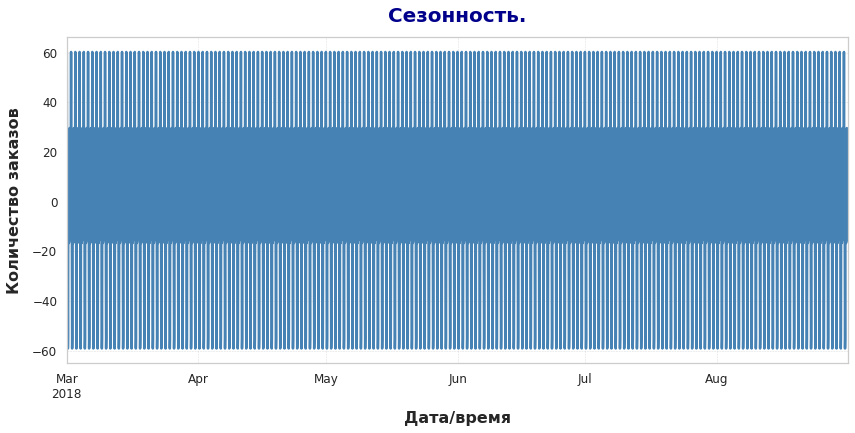

In [18]:
file=decomposed.seasonal
title='Сезонность.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

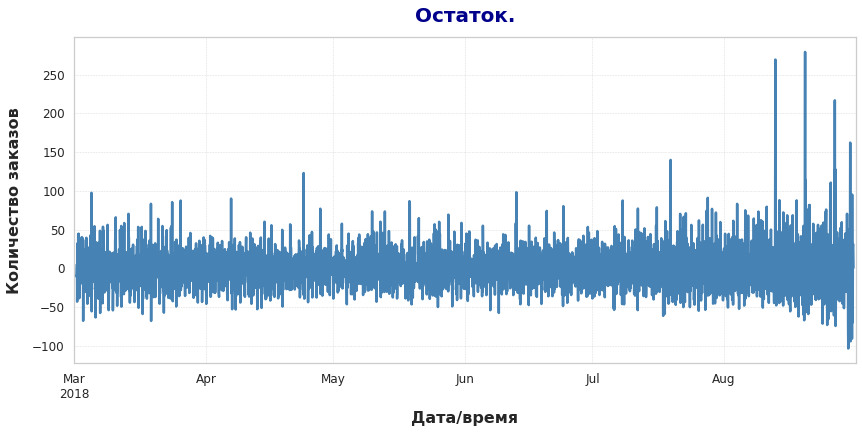

In [19]:
file=decomposed.resid
title='Остаток.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Построим графики для последнего месяца временного ряда (август) и разобьем данные на три компонента: тренд, сезонность и остаточную составляющую.

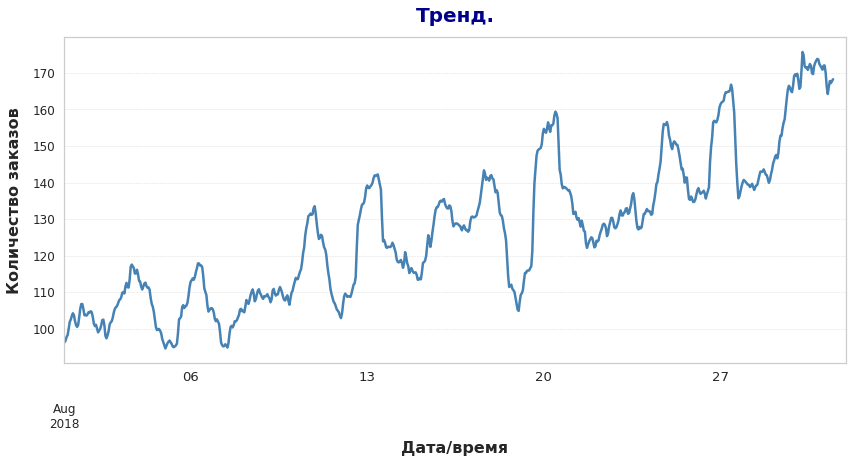

In [20]:
file=decomposed.trend['2018-08':'2018-08']
title='Тренд.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

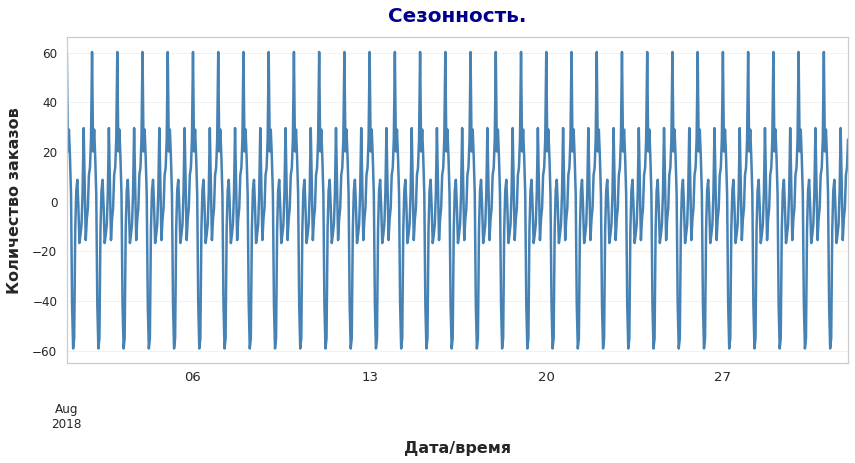

In [21]:
file=decomposed.seasonal['2018-08':'2018-08']
title='Сезонность.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

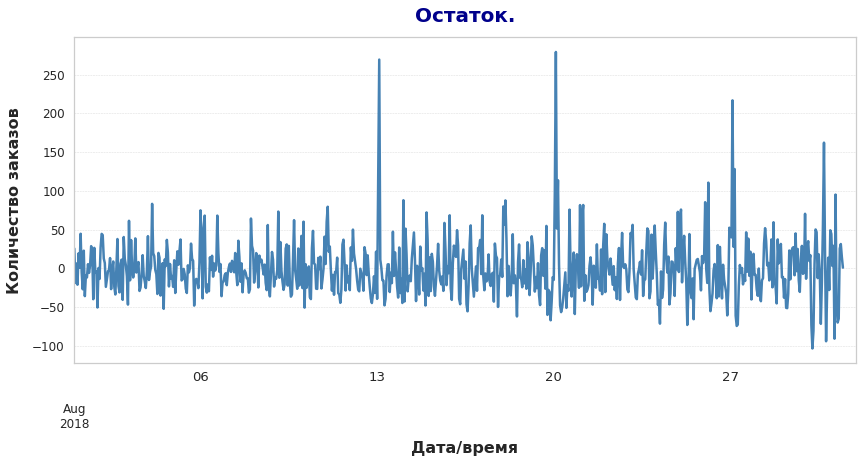

In [22]:
file=decomposed.resid['2018-08':'2018-08']
title='Остаток.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Построим график временного ряда для недели, начиная с понедельника 20 августа 2018 года, и разложим данные на три компонента: тренд, сезонность и остаточную составляющую.

In [23]:
df = taxi['2018-08-20':'2018-08-27']
df['dayofweek'] = df.index.day_name()
df['dayofweek'].unique()
print(*df['dayofweek'].unique(), sep="\n")

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


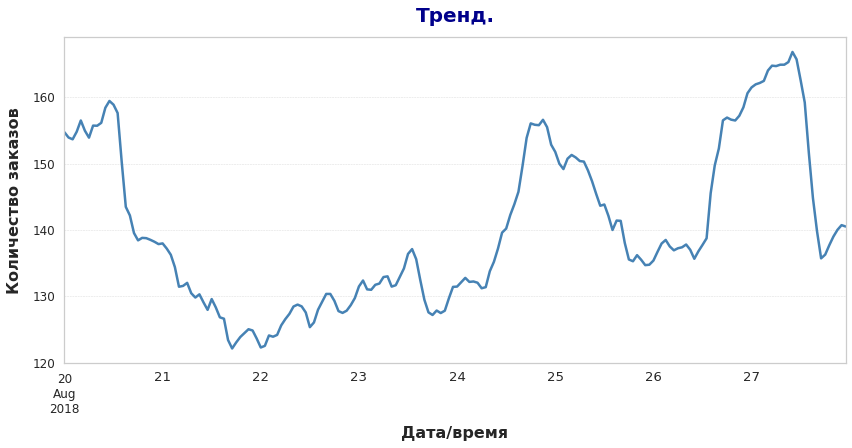

In [24]:
file=decomposed.trend['2018-08-20':'2018-08-27']
title='Тренд.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Отмечается рост спроса на такси в пятницу и выходные дни.

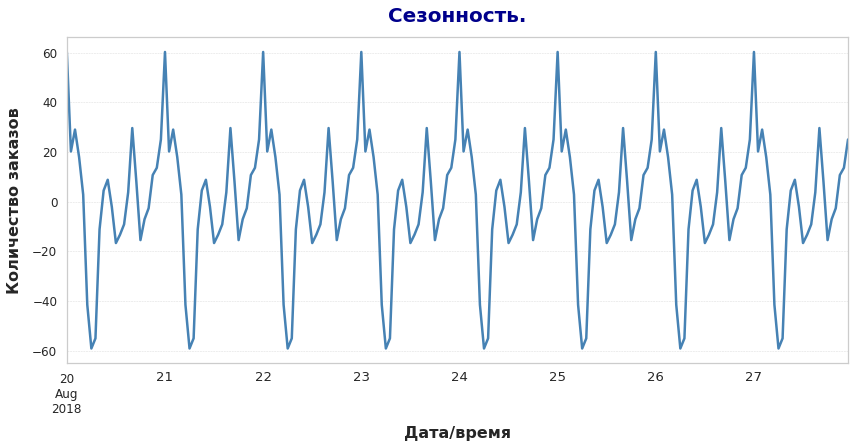

In [25]:
file=decomposed.seasonal['2018-08-20':'2018-08-27']
title='Сезонность.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Сезонная компонента распределяется практически одинаково в течение суток. Заказы такси почти отсутствуют ночью, а пик наблюдается ближе к вечеру.

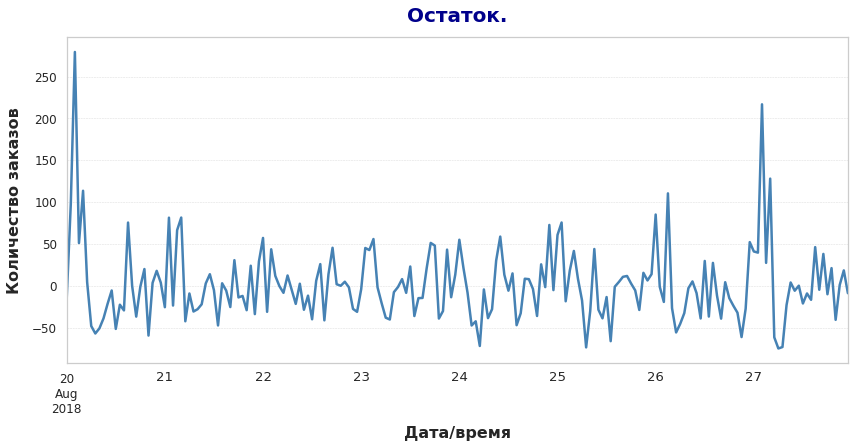

In [26]:
file=decomposed.resid['2018-08-20':'2018-08-27']
title='Остаток.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

Построим графики для обычного буднего дня 24 августа 2018 года и разложим данные на три компонента: тренд, сезонность и остаточную составляющую.

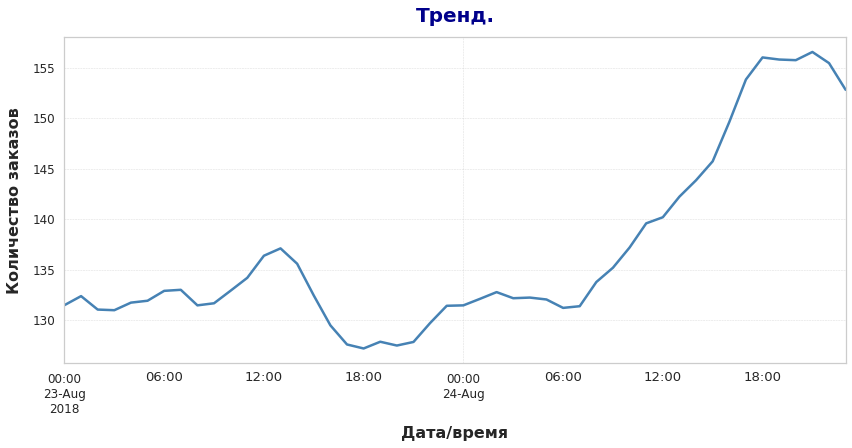

In [27]:
file=decomposed.trend['2018-08-23':'2018-08-24']
title='Тренд.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

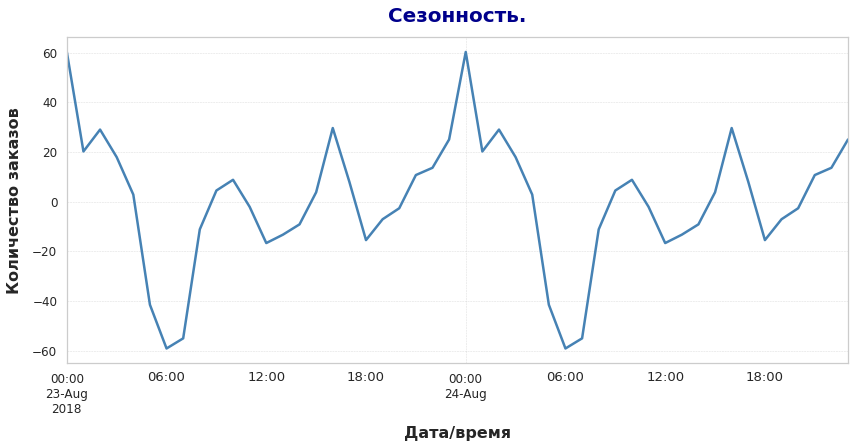

In [28]:
file=decomposed.seasonal['2018-08-23':'2018-08-24']
title='Сезонность.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

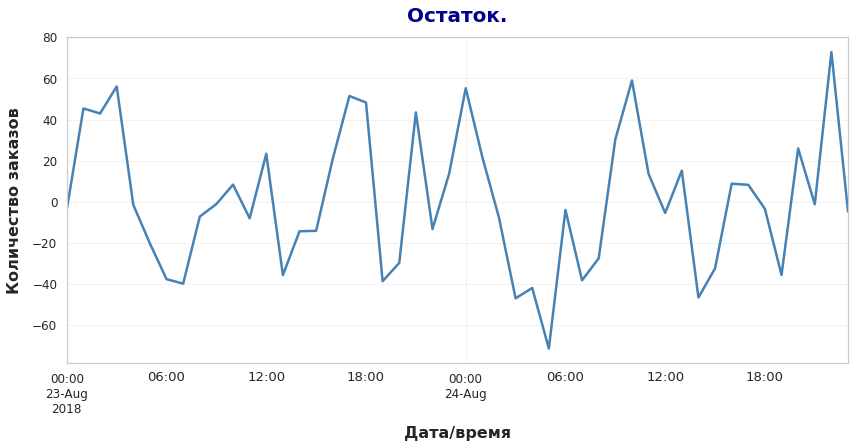

In [29]:
file=decomposed.resid['2018-08-23':'2018-08-24']
title='Остаток.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_decompose(file, title, xlabel, ylabel)

***Вывод:***

- **Максимальное количество заказов** наблюдается в понедельник и четверг.
- **Минимальное количество заказов** — во вторник и среду. Спрос увеличивается по мере приближения выходных.
- **Пиковая нагрузка** приходится на полночь.
- **Меньше всего заказов** поступает между пятью и семью утра.
- **Сезонная компонента** распределяется равномерно в течение суток.
- Ночью **заказы такси редки**, пик активности наступает ближе к вечеру.
- Наблюдается **рост числа заказов** такси к концу летнего сезона.

## Обучение

In [30]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day_of_week'] = df.index.day_name()
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return df

df = make_features(taxi, 168, 168)
df = df.dropna()

train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

display(train.iloc[:, list(range(0, 7)) + list(range(164, 172))].head(10).style.background_gradient(cmap='Blues', axis=0))

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,Thursday,0,94.000000,127.000000,108.000000,76.000000,12.000000,6.000000,43.000000,66.000000,71.000000,85.000000,124.000000,54.226190
2018-03-08 01:00:00,78,Thursday,1,143.000000,94.000000,127.000000,108.000000,15.000000,12.000000,6.000000,43.000000,66.000000,71.000000,85.000000,54.339286
2018-03-08 02:00:00,65,Thursday,2,78.000000,143.000000,94.000000,127.000000,34.000000,15.000000,12.000000,6.000000,43.000000,66.000000,71.000000,54.297619
2018-03-08 03:00:00,68,Thursday,3,65.000000,78.000000,143.000000,94.000000,69.000000,34.000000,15.000000,12.000000,6.000000,43.000000,66.000000,54.261905
2018-03-08 04:00:00,60,Thursday,4,68.000000,65.000000,78.000000,143.000000,64.000000,69.000000,34.000000,15.000000,12.000000,6.000000,43.000000,54.273810
2018-03-08 05:00:00,6,Thursday,5,60.000000,68.000000,65.000000,78.000000,96.000000,64.000000,69.000000,34.000000,15.000000,12.000000,6.000000,54.375000
2018-03-08 06:00:00,6,Thursday,6,6.000000,60.000000,68.000000,65.000000,30.000000,96.000000,64.000000,69.000000,34.000000,15.000000,12.000000,54.375000
2018-03-08 07:00:00,19,Thursday,7,6.000000,6.000000,60.000000,68.000000,32.000000,30.000000,96.000000,64.000000,69.000000,34.000000,15.000000,54.339286
2018-03-08 08:00:00,77,Thursday,8,19.000000,6.000000,6.000000,60.000000,48.000000,32.000000,30.000000,96.000000,64.000000,69.000000,34.000000,54.363095


### Модель линейной регрессии

In [31]:
cat_features = ['day_of_week', 'hour']

In [32]:
def preprocess_data(X_train, X_valid, cat_features):
    encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  

    preprocessor = ColumnTransformer(
        transformers=[('cat', encoder_ohe, cat_features)], 
        remainder='passthrough'
    )

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_valid_transformed = preprocessor.transform(X_valid)

    return X_train_transformed, X_valid_transformed

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']

X_train, X_valid = preprocess_data(X_train, X_valid, cat_features)

lm = LinearRegression()
lm.fit(X_train, y_train)

def calculate_rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred) ** 0.5, 2) 

preds_train = lm.predict(X_train)
print(f'\u001b[38;5;19m RMSE на обучающей выборке = {calculate_rmse(y_train, preds_train)} \u001b[0m')

preds_valid = lm.predict(X_valid)
print(f'\u001b[38;5;19m RMSE на валидационной выборке = {calculate_rmse(y_valid, preds_valid)} \u001b[0m')

 RMSE на обучающей выборке = 18.93 
 RMSE на валидационной выборке = 29.47 


Определим оптимальные гиперпараметры для линейной регрессии.

In [33]:
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48

for lag in range(1, 168, 12):
    for roll_size in range(1, 168, 12):

        df = make_features(taxi, lag, roll_size)
        train, test = train_test_split(df, shuffle=False, test_size=0.2)
        valid, test = train_test_split(test, shuffle=False, test_size=0.5)
        train = train.dropna()
        
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']
        X_valid = valid.drop('num_orders', axis=1)
        y_valid = valid['num_orders']

        encoder_ohe = OneHotEncoder(drop='first', sparse_output=False)  
        encoder_ohe.fit(X_train[cat_features])

        X_train_encoded = pd.DataFrame(encoder_ohe.transform(X_train[cat_features]), columns=encoder_ohe.get_feature_names_out(), index=X_train.index)
        X_valid_encoded = pd.DataFrame(encoder_ohe.transform(X_valid[cat_features]), columns=encoder_ohe.get_feature_names_out(), index=X_valid.index)

        X_train = X_train.drop(cat_features, axis=1)
        X_valid = X_valid.drop(cat_features, axis=1)

        X_train = pd.concat([X_train, X_train_encoded], axis=1)
        X_valid = pd.concat([X_valid, X_valid_encoded], axis=1)

        lm = LinearRegression()
        lm.fit(X_train, y_train)

        preds_valid = lm.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))  

        if rmse < best_rmse_lm:
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            best_y_valid_lm = y_valid
            best_preds_valid_lm = preds_valid
            model_lm = lm

print('\u001b[38;5;19m', 'RMSE на валидационной выборке = ', best_rmse_lm, '\u001b[0m')
print('\u001b[38;5;19m', 'Максимальное смещение = ', best_lag_lm, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер скользящего окна = ', best_roll_size_lm, '\u001b[0m')

 RMSE на валидационной выборке =  29.341275188691437 
 Максимальное смещение =  157 
 Размер скользящего окна =  37 


In [34]:
def line_chart_2(file_1, file_2, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    plt.figure(figsize=(14, 6))
    ax = file_1.plot(kind='line', grid=False, color='steelblue', linewidth=2.5, ax=plt.gca())
    ax = file_2.plot(kind='line', grid=False, color='red', linewidth=2.5, ax=plt.gca())
    plt.legend(['исходная выборка', 'предсказания'], fontsize=16, loc='upper left')
    ax.set_title(title, fontsize=20, fontweight="bold", color='darkblue', pad=15)
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

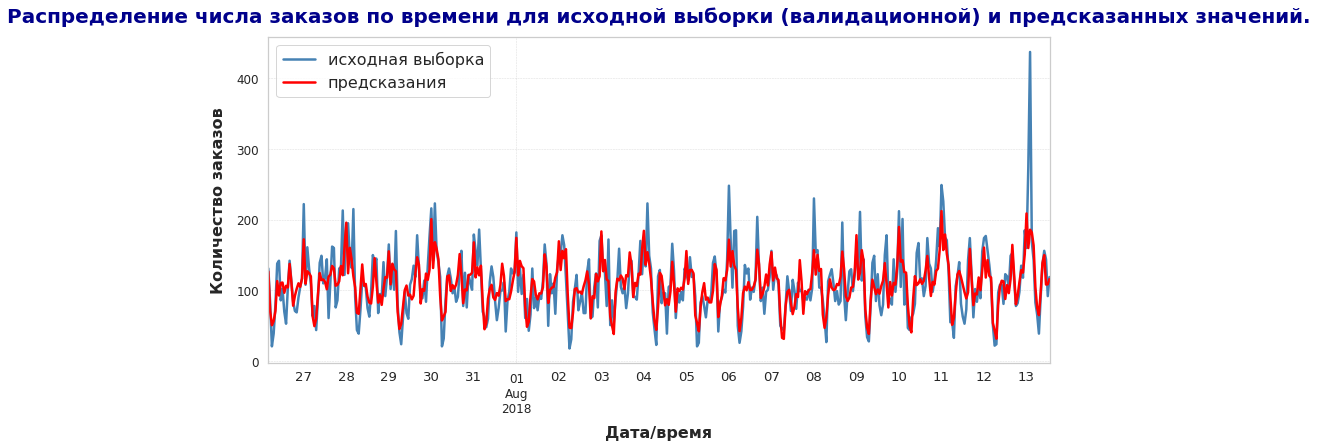

In [35]:
file_1=best_y_valid_lm
file_2=pd.Series(best_preds_valid_lm, index=best_y_valid_lm.index)
title='Распределение числа заказов по времени для исходной выборки (валидационной) и предсказанных значений.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart_2(file_1, file_2, title, xlabel, ylabel)

### Модель Lasso

In [36]:
best_lag_ls = 0
best_roll_size_ls = 0
best_alpha_ls = 0
best_rmse_ls = 48

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

for lag in range(1, 168, 12):
    for roll_size in range(1, 168, 12):
        for alpha in np.arange(0.1, 1, 0.2):

            df = make_features(taxi, lag, roll_size)
            train, test = train_test_split(df, shuffle=False, test_size=0.2)
            valid, test = train_test_split(test, shuffle=False, test_size=0.5)
            train = train.dropna()

            X_train = train.drop('num_orders', axis=1)
            y_train = train['num_orders']
            X_valid = valid.drop('num_orders', axis=1)
            y_valid = valid['num_orders']

            encoder_ohe.fit(X_train[cat_features])

            X_train_encoded = encoder_ohe.transform(X_train[cat_features])
            X_valid_encoded = encoder_ohe.transform(X_valid[cat_features])

            X_train = X_train.drop(cat_features, axis=1)
            X_valid = X_valid.drop(cat_features, axis=1)

            X_train[encoder_ohe.get_feature_names_out()] = X_train_encoded
            X_valid[encoder_ohe.get_feature_names_out()] = X_valid_encoded

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_valid_scaled = scaler.transform(X_valid)

            ls = Lasso(alpha=alpha)
            ls.fit(X_train_scaled, y_train)

            preds_valid = ls.predict(X_valid_scaled)

            rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))

            if rmse < best_rmse_ls:
                best_rmse_ls = rmse
                best_lag_ls = lag
                best_roll_size_ls = roll_size
                best_alpha_ls = alpha
                best_y_valid_ls = y_valid
                best_preds_valid_ls = preds_valid
                model_ls = ls

print('\u001b[38;5;19m', 'RMSE на валидационной выборке = ', best_rmse_ls, '\u001b[0m')
print('\u001b[38;5;19m', 'Максимальное смещение = ', best_lag_ls, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер скользящего окна = ', best_roll_size_ls, '\u001b[0m')
print('\u001b[38;5;19m', 'Коэффициент регуляризации = ', best_alpha_ls, '\u001b[0m')

 RMSE на валидационной выборке =  28.92532758745436 
 Максимальное смещение =  157 
 Размер скользящего окна =  73 
 Коэффициент регуляризации =  0.1 


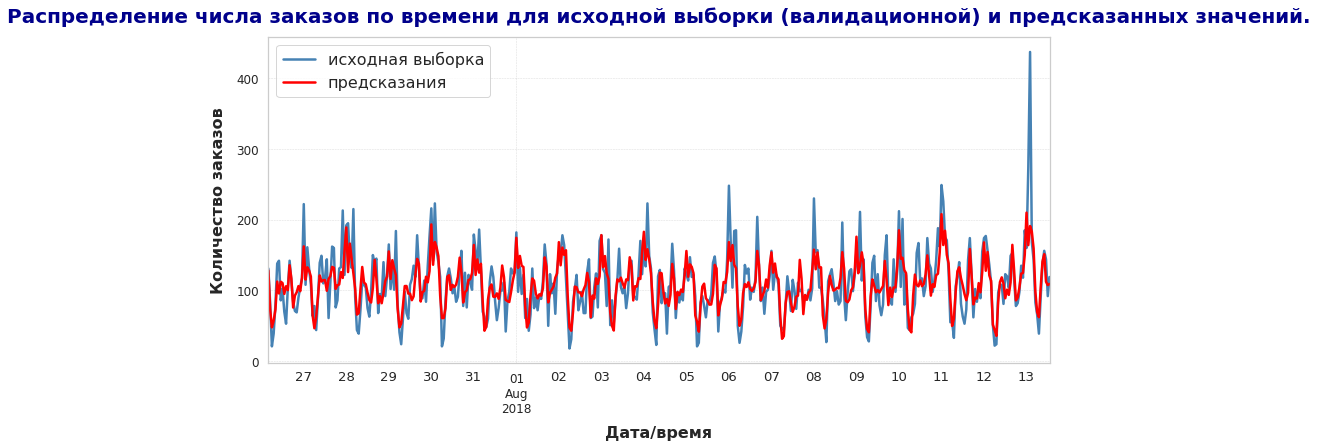

In [37]:
file_1=best_y_valid_ls
file_2=pd.Series(best_preds_valid_ls, index=best_y_valid_ls.index)
title='Распределение числа заказов по времени для исходной выборки (валидационной) и предсказанных значений.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart_2(file_1, file_2, title, xlabel, ylabel)

### Модель Ridge

In [38]:
best_lag_rd = 0
best_roll_size_rd = 0
best_alpha_rd = 0
best_rmse_rd = 48

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

for lag in range(1, 168, 12):
    for roll_size in range(1, 168, 12):
        for alpha in np.arange(0.1, 1, 0.2):

            df = make_features(taxi, lag, roll_size)
            train, test = train_test_split(df, shuffle=False, test_size=0.2)
            valid, test = train_test_split(test, shuffle=False, test_size=0.5)
            train = train.dropna()

            X_train = train.drop('num_orders', axis=1)
            y_train = train['num_orders']
            X_valid = valid.drop('num_orders', axis=1)
            y_valid = valid['num_orders']

            encoder_ohe.fit(X_train[cat_features])

            X_train_encoded = encoder_ohe.transform(X_train[cat_features])
            X_valid_encoded = encoder_ohe.transform(X_valid[cat_features])

            X_train = X_train.drop(cat_features, axis=1)
            X_valid = X_valid.drop(cat_features, axis=1)

            X_train[encoder_ohe.get_feature_names_out()] = X_train_encoded
            X_valid[encoder_ohe.get_feature_names_out()] = X_valid_encoded

            rd = Ridge(alpha=alpha)
            rd.fit(X_train, y_train)

            preds_valid = rd.predict(X_valid)

            rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))

            if rmse < best_rmse_rd:
                best_rmse_rd = rmse
                best_lag_rd = lag
                best_roll_size_rd = roll_size
                best_alpha_rd = alpha
                best_y_valid_rd = y_valid
                best_preds_valid_rd = preds_valid
                model_rd = rd

print('\u001b[38;5;19m', 'RMSE на валидационной выборке = ', best_rmse_rd, '\u001b[0m')
print('\u001b[38;5;19m', 'Максимальное смещение = ', best_lag_rd, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер скользящего окна = ', best_roll_size_rd, '\u001b[0m')
print('\u001b[38;5;19m', 'Коэффициент регуляризации = ', best_alpha_rd, '\u001b[0m')

 RMSE на валидационной выборке =  29.15348534280887 
 Максимальное смещение =  157 
 Размер скользящего окна =  1 
 Коэффициент регуляризации =  0.9000000000000001 


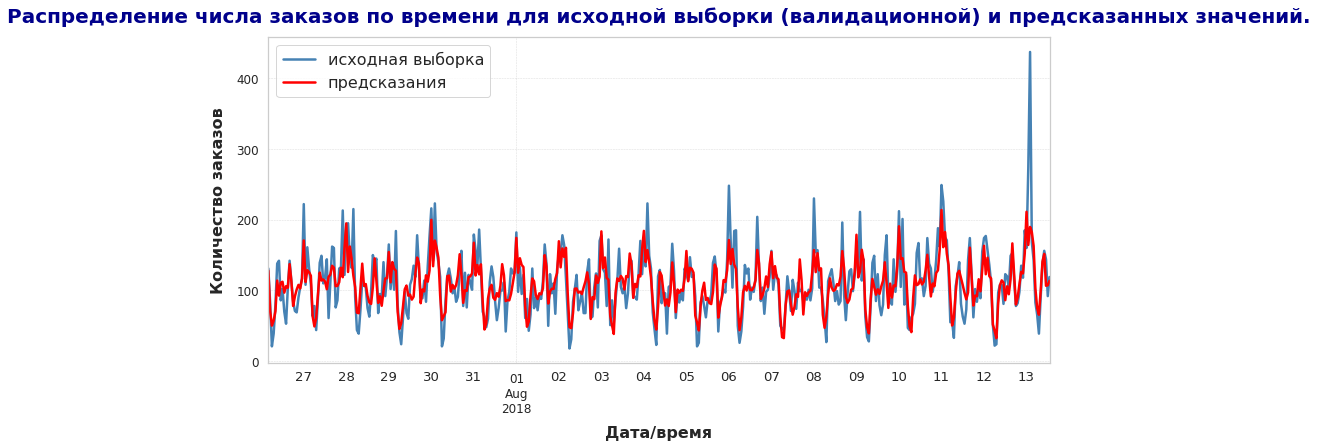

In [39]:
file_1=best_y_valid_rd
file_2=pd.Series(best_preds_valid_rd, index=best_y_valid_rd.index)
title='Распределение числа заказов по времени для исходной выборки (валидационной) и предсказанных значений.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart_2(file_1, file_2, title, xlabel, ylabel)

In [40]:
data = {'RMSE на тестовой выборке':[round(best_rmse_lm, 4), round(best_rmse_ls, 4), round(best_rmse_rd, 4)],
        'Максимальное смещение':[best_lag_lm, best_lag_ls, best_lag_rd],
        'Размер скользящего окна':[best_roll_size_lm, best_roll_size_ls, best_roll_size_rd],
        'Коэффициент регуляризации':[np.nan, best_alpha_ls, best_alpha_rd]}

index = ['LinearRegression', 'Lasso', 'Ridge']

data_final = pd.DataFrame(data=data, index=index)

display(data_final.sort_values(by='RMSE на тестовой выборке', ascending=True).style.background_gradient(cmap='Blues', axis=0))

,RMSE на тестовой выборке,Максимальное смещение,Размер скользящего окна,Коэффициент регуляризации
Lasso,28.925300,157,73,0.100000
Ridge,29.153500,157,1,0.900000
LinearRegression,29.341300,157,37,nan


## Тестирование

Модель Lasso показала наилучший результат, поэтому проведем её тестирование на тестовой выборке с выбранными гиперпараметрами.

In [41]:
lag = best_lag_ls
roll_size = best_roll_size_ls
alpha = best_alpha_ls

df = make_features(taxi, lag, roll_size)
train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(X_train[cat_features])

X_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train[cat_features])
X_train = X_train.drop(cat_features, axis=1)

X_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test[cat_features])
X_test = X_test.drop(cat_features, axis=1)

ls = Lasso(alpha=alpha)
ls.fit(X_train, y_train)

preds_test = ls.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds_test))

print('\u001b[38;5;19m','RMSE лучшей модели Lasso на тестовой выборке = ', rmse, '\u001b[0m')

 RMSE лучшей модели Lasso на тестовой выборке =  38.86335325925227 


In [42]:
def line_chart_1(file, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    plt.figure(figsize=(14, 6))
    ax = file.plot(kind='line', color='green', linewidth=2.5)
    ax.set_title(title, fontsize=20, fontweight="bold", color='darkblue', pad=15)
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(['Разность исходной выборки и предсказания'], fontsize=16, loc='upper left')
    plt.show()

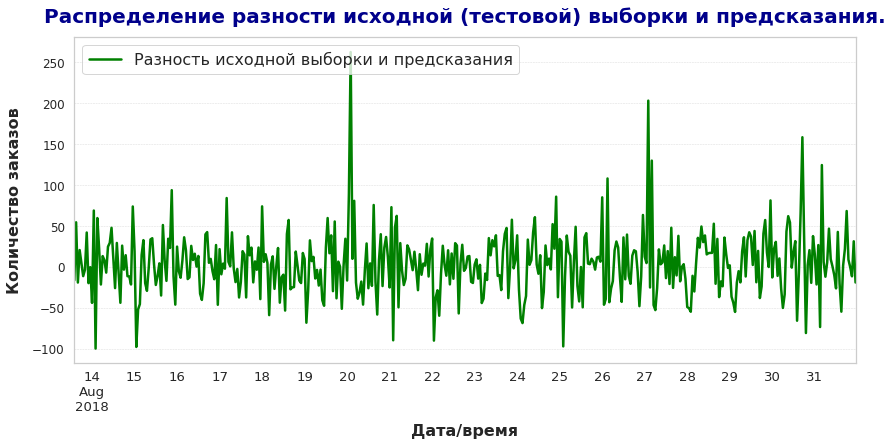

In [43]:
file = y_test - pd.Series(preds_test, index=y_test.index)
title='Распределение разности исходной (тестовой) выборки и предсказания.'
xlabel='Дата/время'
ylabel='Количество заказов'
line_chart_1(file, title, xlabel, ylabel)

In [44]:
dif_1 = (y_test - pd.Series(preds_test, index=y_test.index)).mean()
print(f'\u001b[38;5;19mСредняя разность между данными по количеству заказов исходной выборки и предсказаниями составляет: {round(dif_1, 2)}\u001b[0m')

dif_2 = (y_test - pd.Series(preds_test, index=y_test.index)).max()
print(f'\u001b[38;5;19mМаксимальное смещение предсказания от данных по количеству заказов исходной выборки: {round(dif_2, 2)}\u001b[0m')

Средняя разность между данными по количеству заказов исходной выборки и предсказаниями составляет: 4.06
Максимальное смещение предсказания от данных по количеству заказов исходной выборки: 262.68


## Вывод

Данные заказов такси компании «Чётенькое такси» за период с марта по август 2018 года были загружены и ресемплированы по одному часу. На основе этих данных было построено распределение количества заказов за различные временные промежутки: весь период, месяц, неделю и день. В ходе анализа были выявлены закономерности, включая увеличение заказов в выходные и праздничные дни.

Для прогнозирования количества заказов были обучены модели линейной регрессии, Lasso и Ridge с различными гиперпараметрами, используя 10% данных в качестве тестовой выборки. Гиперпараметры для каждой модели были подобраны с учетом минимального значения метрики RMSE. Все модели удовлетворяют требованию, что их RMSE не превышает значения 48.

Наилучший результат с минимальным значением **RMSE = 38.863** был достигнут с моделью **Lasso**, при этом:
- максимальное смещение составило **157**,
- размер скользящего окна — **73**,
- коэффициент регуляризации равен **0.1**.